# **ANALYTICAL MODELS**

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Dataset

### Create a synthetic dataset

**Helper functions**

In [3]:
def plot_ts_data(time, series, line_style='-', start=0, end=None, label=None):
    """
    Plots the graph for time series data
    """
    plt.plot(time[start:end], series[start:end], line_style, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)


def trend(time, slope=0):
    """
    Creates a line with slope.
    """
    return slope * time

def seasonal_pattern(season_time):
    """
    Creates an arbitrary pattern. You can change it.
    """
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """
    Creates a repititive pattern.
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """
    Creates white noise.
    """
    np.random.seed(seed)
    return np.random.randn(len(time)) * noise_level

**Create a series**

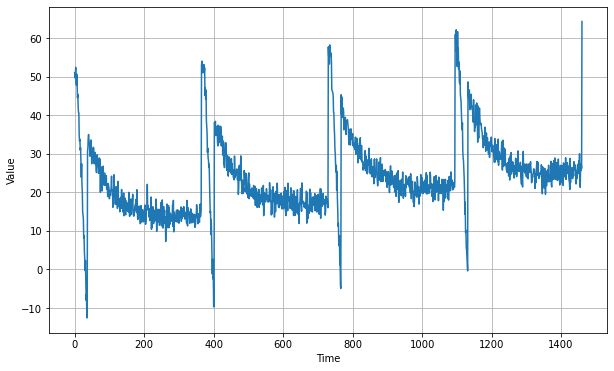

In [4]:
# inputs
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# create the series
series = baseline\
         + trend(time, slope) \
         + seasonality(time, period=365, amplitude=amplitude) \
         + noise(time, noise_level, seed=42)

# show the series in a graph
plt.figure(figsize=(10, 6))
plot_ts_data(time, series)
plt.show()

**Split the dataset**

In [5]:
# time point to split train and validation data
split_time = 1100

# training data
t_train = time[:split_time]    # time
x_train = series[:split_time]  # values

# validation data
t_valid = time[split_time:]    # time
x_valid = series[split_time:]  # values

# check dataset sizes
print(f'size - training: {len(x_train)}, validation: {len(x_valid)}')

size - training: 1100, validation: 361


## Evaluation Metrics

**Mean squarred error (MSE)**
- Use when large error is significantly more critical.

**Mean absolute error (MSE)**
- Use when errors are proportionally critical.

In [6]:
# function for calculating MSE
MSE = lambda actual, prediction: np.mean((actual - prediction)**2)
# function for calculating MAE
MAE = lambda actual, prediction: np.mean(abs(actual - prediction))

## Model-1: Naive Forecast
- Predicts the same value at last time-step.

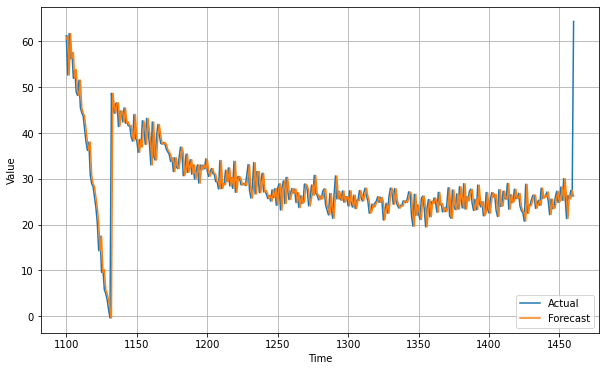

MSE: 19.578306
MAE: 2.601197


In [7]:
# prediction for validation dataset
naive_forecast = series[split_time-1: -1]

# compare in graph
plt.figure(figsize=(10, 6))
plot_ts_data(t_valid, x_valid, label='Actual')
plot_ts_data(t_valid, naive_forecast, label='Forecast')
plt.legend()
plt.show()

# calculate errors
print(f'MSE: {MSE(x_valid, naive_forecast):.6f}')
print(f'MAE: {MAE(x_valid, naive_forecast):.6f}')

## Model-2: Moving Average
- Forecasts the mean of last few values.
- If the window size is 1, it is similar to naive forecast model.

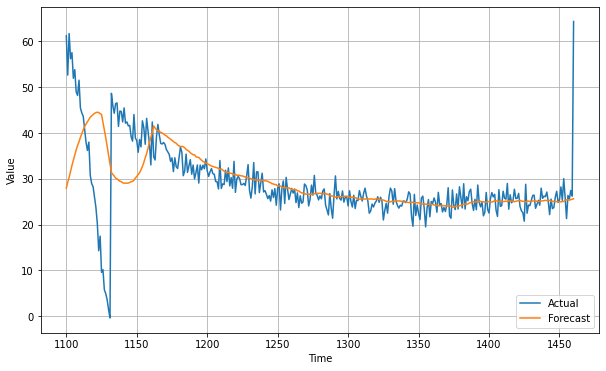

MSE: 65.786215
MAE: 4.304002


In [8]:
def moving_average_forecast(series, window_size):
    """
    Calculates average of last values in the window.
    """
    forecast = []
    for i in range(len(series)-window_size):
        value = np.mean(series[i:i+window_size])
        forecast.append(value)
    return np.array(forecast)


# window size
window_size = 30
# prediction for validation dataset
moving_avg = moving_average_forecast(series, window_size)[split_time-window_size:]

# compare in graph
plt.figure(figsize=(10, 6))
plot_ts_data(t_valid, x_valid, label='Actual')
plot_ts_data(t_valid, moving_avg, label='Forecast')
plt.legend()
plt.show()

# calculate errors
print(f'MSE: {MSE(x_valid, moving_avg):.6f}')
print(f'MAE: {MAE(x_valid, moving_avg):.6f}')

## Differencing
- In stead of forecasting the original values, let's build models for forecasting the difference.
- Let's create the dataset first.
- Differencing removes trend and seasonality from the data. Lets the model forecast better.

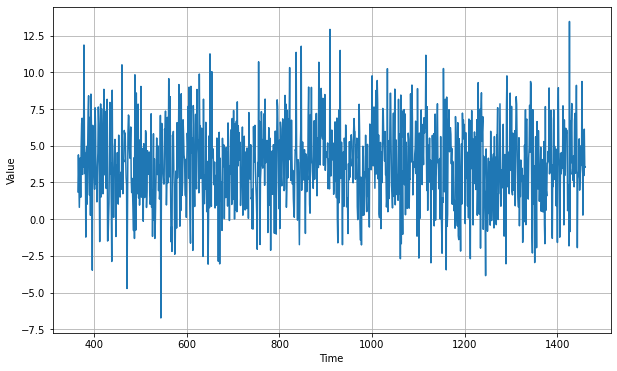

In [9]:
t_diff = 365

diff_series = series[t_diff:] - series[:-t_diff]
diff_time = time[t_diff:]

# plot graph
plt.figure(figsize=(10, 6))
plot_ts_data(diff_time, diff_series)
plt.show()

## Model-3: Moving Average + Forecast Difference

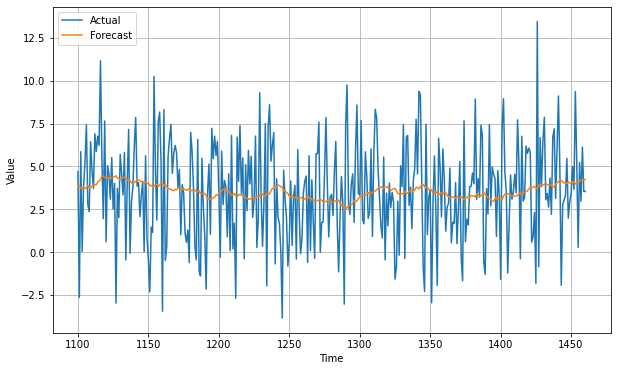

In [10]:
# window size
window_size = 50
# forecast difference by using moving average model
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time-t_diff-window_size:]

# compare in graph
plt.figure(figsize=(10, 6))
plot_ts_data(t_valid, diff_series[split_time-t_diff:], label='Actual')
plot_ts_data(t_valid, diff_moving_avg, label='Forecast')
plt.legend()
plt.show()

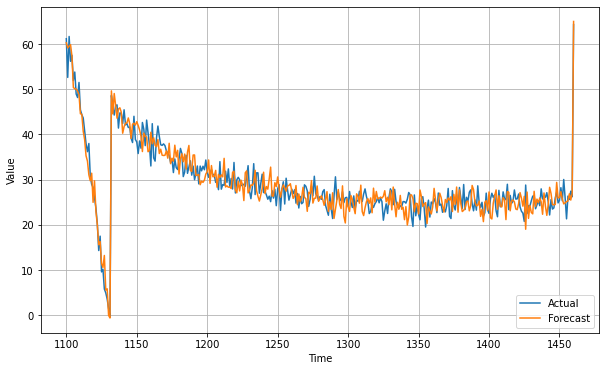

MSE: 8.498154
MAE: 2.327179


In [11]:
# let's bring back the trend and seasonality by adding the past values from t – 365
diff_moving_avg_plus_past = diff_moving_avg + series[split_time-t_diff:-t_diff]

# compare in graph
plt.figure(figsize=(10, 6))
plot_ts_data(t_valid, x_valid, label='Actual')
plot_ts_data(t_valid, diff_moving_avg_plus_past, label='Forecast')
plt.legend()
plt.show()

# calculate errors
print(f'MSE: {MSE(x_valid, diff_moving_avg_plus_past):.6f}')
print(f'MAE: {MAE(x_valid, diff_moving_avg_plus_past):.6f}')

## Model-4: Moving Average + Forecast Difference + Smooth past
- Let's use a moving averaging on past values to remove some of the noise.
- Use centered window to calculate moving average.

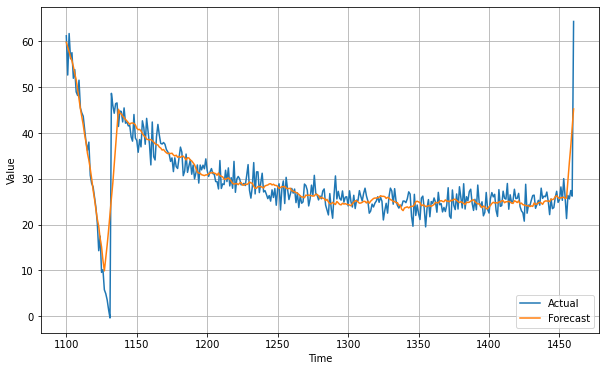

MSE: 12.527959
MAE: 2.203444


In [12]:
# window size for smoothing past
ws_past = 10
# smooth past
moving_avg_past = moving_average_forecast(series, ws_past)[split_time - t_diff - ws_past//2: -t_diff + ws_past//2]

# forecast
diff_moving_avg_plus_smooth_past = diff_moving_avg + moving_avg_past

# compare in graph
plt.figure(figsize=(10, 6))
plot_ts_data(t_valid, x_valid, label='Actual')
plot_ts_data(t_valid, diff_moving_avg_plus_smooth_past, label='Forecast')
plt.legend()
plt.show()

# calculate errors
print(f'MSE: {MSE(x_valid, diff_moving_avg_plus_smooth_past):.6f}')
print(f'MAE: {MAE(x_valid, diff_moving_avg_plus_smooth_past):.6f}')
